## Full demo notebook for pose estimation 
**This notebook demonstrates the coarse-to-fine, bottom-up approach to pose estimation for an object with known identity.**

### Setup

In [1]:
import Pkg
Pkg.activate("../../");  # setup InverseGraphics environment


  Activating project at `C:\SY\MIT\UROP\InverseGraphics\InverseGraphics`


In [2]:
# Pkg.precompile()

In [3]:
import Revise
import GLRenderer as GL
import Images as I
import MiniGSG as S
import Rotations as R
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN

In [4]:
import InverseGraphics as T
import NearestNeighbors
import LightGraphs as LG
import StaticArrays
import ProgressMeter
import Serialization


In [5]:
using Distributions
import Gen
using ProgressMeter
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

In [ ]:
V.setup_visualizer()

In [7]:
# Load the YCB object models
YCB_DIR = joinpath(dirname(dirname(pwd())),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
all_ids = sort(collect(keys(id_to_cloud)));
names = T.load_ycb_model_list(YCB_DIR);

In [8]:
# Initialize the canera intrinsics and renderer that will render using those intrinsics.
camera = GL.CameraIntrinsics()
camera = T.scale_down_camera(camera, 5.5)
camera_pose = IDENTITY_POSE

Pose⟨pos=[0, 0, 0], orientation=(w=1.0, x=0.0, y=0.0, z=0.0)⟩

In [9]:
# Initialize renderer and load all ycb objects
renderer = GL.setup_renderer(camera, GL.DepthMode())
resolution = 0.05

for id in all_ids
    cloud = id_to_cloud[id]
    mesh = GL.mesh_from_voxelized_cloud(GL.voxelize(cloud, resolution), resolution);
    GL.load_object!(renderer, mesh)
end
@show length(all_ids)

gl_version_for_shaders = "460"
true
length(all_ids) = 21


21

### Introductory visualizations
Visual examples of coarse-to-fine rendering

#### "Radius" ($r$ in likelihood) scaling
$$p(Y \vert \textbf{O}^M, \textbf{x}_v) = \prod_{i=1}^{K} (C \cdot \frac{1}{B} + \frac{1-C}{\tilde{K}} \sum_{j=1}^{\tilde{K}}\frac{\mathbf{1} (\vert\vert{y_i - \tilde{y_i}}\vert\vert  \leq r)}{\frac{4}{3}\pi r^3}) 
\label{equation:likelihood}$$



Infinite mixture (for $K$, the # of points in the sampled cloud) of finite mixtures (each sphere centered at template cloud point)


names[sample_id] = "005_tomato_soup_can"
true


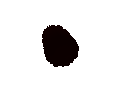

In [10]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0, 100.0)  # world bounds

sample_id = rand(all_ids)  # choose some object in all_ids
@show names[sample_id]
sample_pose = Pose([0.0, 0.0, 3.0], R.RotXYZ(0.4, -0.2, 0.4))  # and a random pose

# Reset the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera) 

# And render the same image as above.
gt_depth_image = GL.gl_render(renderer, [sample_id], [sample_pose], camera_pose)
IJulia.display(GL.view_depth_image(gt_depth_image))

# Create point cloud corresponding to that rendered depth image.
gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera);

Try varying the radius between small (0.01) to large (10) and observe the sampled point cloud visualization

In [ ]:
# radius = 0.01 
# radius = 0.1
radius = 1.0
# radius = 10.0

sampled_cloud = T.voxelize(Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds), 0.005)

# Visualize the point cloud.
V.setup_visualizer()
V.viz(sampled_cloud, color=I.colorant"red", channel_name=:origin)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))


function move_points_to_frame_b(points_in_frame_a::Matrix{<:Real}, b_relative_to_a::Pose)
    if size(points_in_frame_a)[1] != 3
        error("expected an 3 x n matrix")
    end
    n = size(points_in_frame_a[2])
    return b_relative_to_a.orientation * points_in_frame_a .+ b_relative_to_a.pos
end

#### Camera downscaling
Alternatively, we can downscale the camera resolution to generate depth images of different coarseness

scale down by 3.0
true


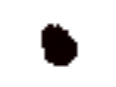

true
scale down by 4.0
true


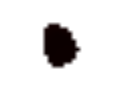

true
scale down by 5.0
true


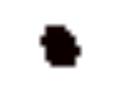

true
scale down by 6.0
true


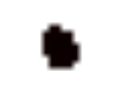

true


In [12]:
using IJulia

final = 6
for downscale_factor=:3.0:final
    println("scale down by $downscale_factor")
    
    # scale camera according to resolution; reset renderer
    scaled_camera = GL.scale_down_camera(camera, downscale_factor)
        
    # Set the renderer to now have those scaled down intrinsics.
    GL.set_intrinsics!(renderer, scaled_camera)
 
    d = GL.gl_render(renderer, [sample_id], [sample_pose], IDENTITY_POSE)

    img = GL.view_depth_image(d)
    img = I.imresize(img, (camera.height, camera.width));
    IJulia.display(img)
  
    # revert intrinsics
    GL.set_intrinsics!(renderer, camera)

end


### Enumerative inference setup

#### Cloud helper functions

In [13]:
# generative model trace visualization
function viz_trace(trace)
    V.setup_visualizer()
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=:gen);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=:obs);
end

viz_trace (generic function with 1 method)

In [14]:
# Get point cloud from the object ids, object poses, and camera pose

# Render and calculate pc
function get_cloud_nocache(poses, ids)
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, renderer.camera_intrinsics)
    if isnothing(cloud)
        cloud = zeros(3,1)
    else
        cloud = T.move_points_to_frame_b(cloud, camera_pose)
    end
    cloud
end

# Get cloud from cache
function get_cloud_func_cached(p, id)
    idx1 = argmin(sum((dirs .- (p.orientation * [1,0,0])).^2, dims=1))[2]
    idx2 = argmin([abs(R.rotation_angle(inv(p.orientation) * r)) for r in rotations_to_enumerate_over[idx1,:]])
    # closest_orientation = rotations_to_enumerate_over[idx1,idx2]
    c = T.move_points_to_frame_b(cloud_lookup[id][idx1,idx2], p)
end

get_cloud_func_cached (generic function with 1 method)

In [15]:
# generate cached renderings of all objects at all rotations, positioned at reference frame
function generate_cloud_cache()
    cloud_lookup = []
    @showprogress for id in all_ids
        cloud = 
        [
            let
                position = [0.0, 0.0, 10.0]
                pose = Pose(position, rotations_to_enumerate_over[i,j])
                d = T.GL.gl_render(renderer, [id], [pose], IDENTITY_POSE);
                c = T.GL.depth_image_to_point_cloud(d, camera)
                c = T.get_points_in_frame_b(c, pose)  # gets the cloud in the render pose reference frame
            end
            for i = 1:size(rotations_to_enumerate_over,1), j = 1:size(rotations_to_enumerate_over,2)
        ]
        push!(cloud_lookup, cloud)    
    end 
    
    return cloud_lookup
end


generate_cloud_cache (generic function with 1 method)

#### Inference helper functions

In [16]:
function precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, first_candidate_obj, last_candidate_obj, rotations_to_enumerate_over)
    # initialize a state of initial particles with various rotations
    all_scored_traces = []
    x, y, z = gt_pose.pos
    gt_position = [x,y,z]
    @Threads.threads for obj_id=first_candidate_obj:last_candidate_obj
        scored_traces = map(orn -> 
                        Gen.generate(model, (init_radius, renderer, gt_position),                 
                                    Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
                                                :id => obj_id, 
                                                T.floating_pose_addr(1) => Pose(gt_position, orn))),
                                    rotations_to_enumerate_over[:]);
    
        all_scored_traces = vcat(all_scored_traces, scored_traces)
    end
    return all_scored_traces
    
end 

precompute_enumerations (generic function with 1 method)

In [17]:
function icp_move_no_unexplained(trace, i, inf_radius, renderer, cam_pose; iterations=10)
    # get_cloud_func needs to give the points in the world frame
#     get_cloud_func = (poses, ids, cam_pose) -> get_cloud_nocache([poses], [ids])  
    get_cloud_func = (pose, id, cam_pose) -> get_cloud_func_cached(pose, id);

    id = Gen.get_choices(trace)[:id]  
    addr = T.floating_pose_addr(1)
    
    obs_cloud = T.move_points_to_frame_b(T.get_obs_cloud(trace), cam_pose)
    c1_tree = NearestNeighbors.KDTree(obs_cloud);

    refined_pose = trace[addr]
    
    refined_pose = T.icp_object_pose(
        refined_pose,
        obs_cloud,
        p -> T.voxelize(get_cloud_func(p, id, cam_pose), v_resolution(inf_radius)),
        c1_tree=c1_tree,
        iterations=iterations
    );

    acceptances = false
     
    for _ in 1:iterations
        trace, acc = T.pose_mixture_move(
            trace, addr, [trace[addr], refined_pose], [0.5, 0.5], 1e-2, 5000.0
        )
        acceptances = acc || acceptances
    end
    
    trace, acceptances, refined_pose
end

icp_move_no_unexplained (generic function with 1 method)

In [18]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state_from_enum(scored_traces, num_particles, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)#(t -> t[2]).(scored_traces)  
    
    _, norm_log_weights = Gen.normalize_weights(log_weights)       
    
    # sample initial set of particles
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles)
    selected_log_weights = Vector{Float64}(undef, num_particles)
    for i=1:num_particles
        trace_idx = Gen.random(Gen.categorical, exp.(norm_log_weights))   
        selected_traces[i] = traces[trace_idx]
        selected_log_weights[i] = norm_log_weights[trace_idx]
    end
    
    println("Initial particle state computed"); flush(stdout)

#     # visualize pdf of initial weights (?)
#     plot(selected_log_weights, seriestype=:stephist, fmt = :png)
    
    # see intermediate results
    top_n = min(5, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];
    if vis
        viz_trace(best_trace);
    end
    println("top$top_n traces:")
    for idx in p
       println("curr_weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(selected_traces[idx]).ori), " id=", Gen.get_retval(selected_traces[idx]).id) 
    end
    flush(stdout)
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state_from_enum

In [19]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state(scored_traces, num_particles, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)#(t -> t[2]).(scored_traces)  
    
     _, norm_log_weights = Gen.normalize_weights(log_weights)    
    flush(stdout)
    
    # sample initial set of particles
    num_particles_per_obj = num_particles ÷ num_candidate_objs
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles_per_obj * num_candidate_objs)
    selected_log_weights = Vector{Float64}(undef, num_particles_per_obj * num_candidate_objs)
        
    stepsize = num_rotations_to_enumerate_over ÷ num_candidate_objs
    
    for i=0:num_candidate_objs-1  # TODO: Avoid globals
        for j = 1:num_particles_per_obj
            trace_idx = stepsize * i + 
                        Gen.random(Gen.categorical, 
                        exp.(Gen.normalize_weights(log_weights[stepsize*i+1:stepsize*(i+1)])[2]))   
            selected_traces[num_particles_per_obj*i+j] = traces[trace_idx]
            selected_log_weights[num_particles_per_obj*i+j] = norm_log_weights[trace_idx]
        end        
    end
     
    
    println("Initial particle state computed ($num_particles_per_obj particles per object)"); flush(stdout)

    
    # see intermediate results
    top_n = min(10, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];
    if vis
        viz_trace(best_trace);
    end
    if topnprint
        println("top$top_n traces:")
        for idx in p
           println("curr_weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(selected_traces[idx]).ori), " id=", Gen.get_retval(selected_traces[idx]).id) 
        end
        flush(stdout)
    end
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state

Note the parallelization via @Threads (there is no significant performance gain for this demo example (few objects))

In [20]:
"""
Overloads the Gen function
Perform a particle filter update, where the model arguments are adjusted, new observations are added, 
and the default proposal is used for new latent state.
"""
function particle_filter_step!(state::Gen.ParticleFilterState{U}, new_args::Tuple, argdiffs::Tuple,
        observations) where {U}    
    log_incremental_weights = Vector{Float64}(undef, num_particles) 
    radius::Float64 = new_args[1]
#     centroid::Vector{Float64} = new_args[end]
    
    @Threads.threads for i=1:num_particles
    ## do mh, drift moves, etc. tune particle before update (i.e. new likelihood)
        state.traces[i], acc, _ = icp_move_no_unexplained(state.traces[i], Gen.get_retval(state.traces[i]).id, 
                                            radius, renderer, camera_pose; iterations=15)

        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 500.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 1000.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 1000.0)
        
        
        # evolve the particle (with new radius involved in new_args)
        (state.new_traces[i], increment, _, discard) = Gen.update(
            state.traces[i], new_args, argdiffs, observations)
#         if !isempty(discard)
#             error("Choices were updated or deleted inside particle filter step: $discard")
#         end
        log_incremental_weights[i] = increment
        state.log_weights[i] += increment
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp
    
    return log_incremental_weights
end

particle_filter_step!

In [21]:
## Control rotation enumeration / update render cache

unit_sphere_directions = T.fibonacci_sphere(60);
other_rotation_angle = collect(0:0.24:(2*π));
rotations_to_enumerate_over = [
    let
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir...), ang, 1)
    end
    for dir in unit_sphere_directions, 
        ang in other_rotation_angle
];
@show num_rotations_to_enumerate_over = length(rotations_to_enumerate_over)
dirs = hcat(unit_sphere_directions...)

# cloud_lookup = generate_cloud_cache()
# Serialization.serialize("render_caching_data.data", (cloud_lookup, rotations_to_enumerate_over, unit_sphere_directions, other_rotation_angle, dirs))
# @show length(cloud_lookup)

(cloud_lookup, rotations_to_enumerate_over, unit_sphere_directions, other_rotation_angle, dirs) = 
Serialization.deserialize("render_caching_data_200_10.data");

num_rotations_to_enumerate_over = length(rotations_to_enumerate_over) = 1620


#### Model & main particle filter function

In [22]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,300.0)

# distance between two points on the pointcloud 
v_resolution = radius -> radius * 0.6   # TODO: experiment with relation btwn resolution and likelihood radius 

"""sample point clouds at the given camera resolution and radius"""
Gen.@gen function model(radius, renderer, centroid, delta=0.9)
    
    # sample object id  
    i = {:id} ~ Gen.uniform_discrete(first_candidate_obj, last_candidate_obj )

    # sample pose
    xc, yc, zc = centroid
    p = {T.floating_pose_addr(1)} ~ T.uniformPose(xc-delta, xc+delta, yc-delta, yc+delta, zc-delta, zc+delta)
#     gt_cloud = get_cloud_nocache([p], [i])    
    gt_cloud = get_cloud_func_cached(p, i);

    voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
    obs_cloud = {T.obs_addr()} ~ T.uniform_mixture_from_template(voxelized_cloud, 0.0001, radius, bounds)
         
    (id=i, pose=p, pos=p.pos, ori=p.orientation, cloud=gt_cloud, voxelized_cloud=voxelized_cloud, rendered_clouds=[voxelized_cloud], obs_cloud=obs_cloud)

end
 

model

In [23]:
"""Particle filter on the evolution of agent knowledge over time; resolution control with radius"""
function particle_filter(renderer, init_radius::Float64, final_radius::Float64, radius_step::Float64, scored_traces,
                        gt_obj_id::Int, gt_pose::Pose, centroid, num_particles::Int, num_samples::Int, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    
    # initialize renderer and particle filter
    GL.set_intrinsics!(renderer, camera)  
#     gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
    gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id)
    gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))
    
    println("\ninitializing particle filter at radius $init_radius") 
    flush(stdout)
    
    
    # initialize a state of initial particles with various rotations  
    state::Gen.ParticleFilterState{U} = generate_initial_pf_state(scored_traces, num_particles)

    
    # evolve over resolutions (modify sphere radius `r` of mixture point cloud likelihood)
    @assert(radius_step < 0.0)
    for radius in init_radius+radius_step:radius_step:final_radius-eps()
        println("\n========Radius=$radius========"); flush(stdout)
        Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)  
        
        # update pf 
        gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
        observations = Gen.choicemap(T.obs_addr() => gt_voxelized_cloud) 
        current_log_weights = particle_filter_step!(state, (radius, renderer, centroid),   
                                                    (Gen.UnknownChange(),), observations)    
        
        # see intermediate results
        top_n = min(5, num_particles-1)
        _, norm_log_weights = Gen.normalize_weights(current_log_weights)
        p = sortperm(norm_log_weights)[end-top_n:end]; 
        
        best_trace = state.traces[argmax(norm_log_weights)];
        
        if vis
            viz_trace(best_trace);
        end
        if topnprint
            println("top$top_n traces:")
            for idx in p
               println("weight=", norm_log_weights[idx], " ori=", (Gen.get_retval(state.traces[idx]).ori)[1:3], "  id=", Gen.get_retval(state.traces[idx]).id) 
            end
            flush(stdout)
        end
        
    end;
    
    # normalize final weights
    log_total_weight, norm_weights = Gen.normalize_weights(state.log_weights)
    return [norm_weights, Gen.sample_unweighted_traces(state, num_samples)]
    
end

particle_filter

### Conduct enumerative inference 

Choose object to infer:

(for pose-only inference, first = last = gt_id)
(to add object id inference as well, specify the range of objects to consider with first_candidiate_obj and last_candidate_obj)


In [24]:
# 1) Choose gt object
# enumerate between objects with id in range [first_candidate_obj, last_candidate_obj]

@show first_candidate_obj = last_candidate_obj = gt_obj_id = rand(1:length(all_ids))  # choose some random obj
num_candidate_objs = last_candidate_obj - first_candidate_obj + 1 #length(all_ids)
@show object = names[gt_obj_id]


first_candidate_obj = (last_candidate_obj = (gt_obj_id = rand(1:length(all_ids)))) = 15
object = names[gt_obj_id] = "035_power_drill"


"035_power_drill"

**Configure pf with parameters below:**

In [25]:
num_particles_per_obj = 4  # note that few particles suffice
num_particles = num_candidate_objs * num_particles_per_obj
num_samples = num_particles  # number of samples to take from final pf state
num_steps = 3
final_radius = float(0.05)# low to high "focus"
init_radius = float(0.30)  # high num = faster enum
radius_step = (final_radius - init_radius)/num_steps

topnprint, vis = true, false  # print info on top particles / meshcat viz top trace




(true, false)

Choose pose to infer 

In [26]:
# 2) Choose gt pose
gx, gy, gz = Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0), Gen.uniform(0.0, 5.0)
@show gt_position = [gx, gy, gz]
tr, _ = Gen.generate(model, (init_radius, renderer, gt_position), Gen.choicemap(:id => gt_obj_id))
gt_pose = T.Pose(pos=gt_position, orientation=Gen.get_retval(tr).ori)

gt_position = [gx, gy, gz] = [3.7895996096353715, 0.16365652266381758, 3.1785346468769973]


Pose⟨pos=[3.7895996096353715, 0.16365652266381758, 3.1785346468769973], orientation=(w=0.20556976341211106, x=-0.7235405567471094, y=0.5230588790278129, z=-0.4007986329604177)⟩

precompute enumeration; run the below code once and comment out

In [27]:
# gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id);
gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))

# get centroid (at a finer resolution)
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1e-10)))


@time enum_ori_traces = precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, 
    first_candidate_obj, last_candidate_obj, rotations_to_enumerate_over);



  3.941476 seconds (15.65 M allocations: 1.974 GiB, 12.93% gc time, 19.02% compilation time)


Run particle filter; generate traces

In [33]:
@time weights, pf_traces = particle_filter(renderer, init_radius, final_radius, radius_step,
                                    enum_ori_traces, gt_obj_id, gt_pose, centroid, num_particles, num_samples);


true

initializing particle filter at radius 0.3
Initial particle state computed (4 particles per object)
top3 traces:
curr_weight=-1.3862943611198943 ori=[0.6070474850634116, 0.1877817923644695, -0.45235838400720324, -0.625782104052973] id=15
curr_weight=-1.3862943611198943 ori=[0.6070474850634116, 0.1877817923644695, -0.45235838400720324, -0.625782104052973] id=15
curr_weight=-1.3862943611198943 ori=[0.6070474850634116, 0.1877817923644695, -0.45235838400720324, -0.625782104052973] id=15
curr_weight=-1.3862943611198943 ori=[0.6070474850634116, 0.1877817923644695, -0.45235838400720324, -0.625782104052973] id=15

========Radius=0.21666666666666667========
effective sample size: 4.00000000000003, doing resample: false
top3 traces:
weight=-177.448902068503 ori=[-0.14271988876313058, -0.9346906221230954, 0.32555256759328455]  id=15
weight=-119.9227904102762 ori=[-0.20841982573995468, -0.952767443598743, 0.220896751123333]  id=15
weight=-91.55581806514414 ori=[-0.2377744874197171, -0.933998

### results
Quantify the localization error (of the highest-weight trace); units are in centimeters

In [29]:
function pose_error(object_cloud, ground_truth_pose, predicted_pose)
    tree = NearestNeighbors.KDTree(T.move_points_to_frame_b(object_cloud, predicted_pose))
    _, dists = NearestNeighbors.nn(tree, T.move_points_to_frame_b(object_cloud, ground_truth_pose))
    sum(dists) ./ length(dists) * 10    # scale to cm
end

pose_error (generic function with 1 method)

In [32]:
obj_cloud = id_to_cloud[gt_obj_id] 

@time @show pose_error(obj_cloud, gt_pose, (Gen.get_retval(pf_traces[argmax(weights)]).pose))

pose_error(obj_cloud, gt_pose, (Gen.get_retval(pf_traces[argmax(weights)])).pose) = 0.9233203952422492
  0.016229 seconds (18.45 k allocations: 3.102 MiB)


0.9233203952422492